In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [41]:
PROJECT_CODE = "001"

DS = Path("../../datasets/")
EXP_BASE = DS / "T004-taco-crops" / PROJECT_CODE
OUTS = EXP_BASE / "synth"
LOG_BASE = EXP_BASE / "log"
TACO_BASE_DIR = Path("/Users/hariomnarang/Desktop/personal/TACO/data/")
ANN_FILE = TACO_BASE_DIR / "annotations.json"
TEST_BIG_IMG = "/Users/hariomnarang/Desktop/personal/roads/datasets/T003-extract-and-place-on-backdrops-manually/images/14325/raw.jpg"

LOG_BASE.mkdir(parents=True, exist_ok=True)
DS.exists(), TACO_BASE_DIR.exists(), ANN_FILE.exists()

(True, True, True)

# Generate Data

In [4]:
# generate data first

from mtrain.smallnet import extract_all

In [5]:
import shutil

shutil.rmtree(OUTS)
extract_all(TACO_BASE_DIR, ANN_FILE, OUTS, 50, 5000)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


Generating samples: 5002iteration [02:36, 32.06iteration/s]                   

total cycles: 2


# Training

In [ ]:
from fastai.vision.all import (
    DataBlock,
    CategoryBlock,
    ImageBlock,
    get_image_files,
    RandomSplitter,
    parent_label,
)

dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
)


dls = dbl.dataloaders(OUTS, path=LOG_BASE)
dls.valid.show_batch(max_n=4, nrows=1)

In [21]:
from fastai.vision.all import (
    vision_learner,
    mobilenet_v3_small,
    CrossEntropyLossFlat,
)
from fastai.callback.progress import CSVLogger, Recorder, ProgressCallback

In [ ]:
learner = vision_learner(dls, mobilenet_v3_small, normalize=True, pretrained=True)
learner = learner.remove_cbs([ProgressCallback])
learner = learner.add_cb(CSVLogger)

In [31]:
learner.fine_tune(10)

[0, 0.6704698801040649, 0.8745170831680298, '00:06']
[0, 0.46069100499153137, 0.9539707899093628, '00:08']
[1, 0.3692852854728699, 0.6587792038917542, '00:08']
[2, 0.3423748314380646, 0.5984047651290894, '00:07']
[3, 0.30394527316093445, 0.43964460492134094, '00:06']
[4, 0.27040088176727295, 0.3391488194465637, '00:08']
[5, 0.23712214827537537, 0.2532862722873688, '00:08']
[6, 0.22443599998950958, 0.2037893831729889, '00:08']
[7, 0.18859390914440155, 0.20494478940963745, '00:09']
[8, 0.18157190084457397, 0.2007972151041031, '00:09']
[9, 0.1785021275281906, 0.19957658648490906, '00:07']


In [32]:
learner.unfreeze()
learner.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

[0, 0.18020443618297577, 0.1975768804550171, '00:20']
[1, 0.17688333988189697, 0.19741415977478027, '00:12']
[2, 0.1683528870344162, 0.19579225778579712, '00:07']
[3, 0.16860073804855347, 0.19446881115436554, '00:07']
[4, 0.17607742547988892, 0.195585235953331, '00:08']
[5, 0.16312026977539062, 0.19234761595726013, '00:06']
[6, 0.17425647377967834, 0.1899431198835373, '00:06']
[7, 0.1655069887638092, 0.1890982836484909, '00:08']
[8, 0.17457108199596405, 0.18915823101997375, '00:08']
[9, 0.1693446934223175, 0.1894841343164444, '00:08']


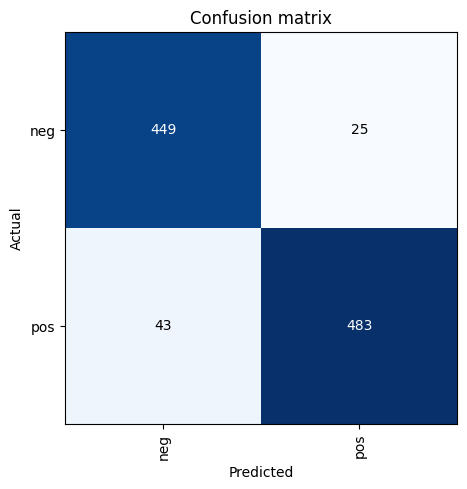

In [33]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

('pos', tensor(1), tensor([0.1951, 0.8049]))


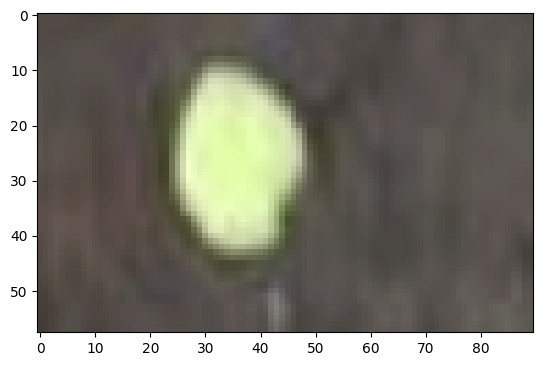

In [55]:
testimg = "/Users/hariomnarang/Desktop/test-img-3.png"
plt.imshow(plt.imread(testimg))
print(learner.predict(testimg))

100%|██████████| 336/336 [00:06<00:00, 50.38it/s]


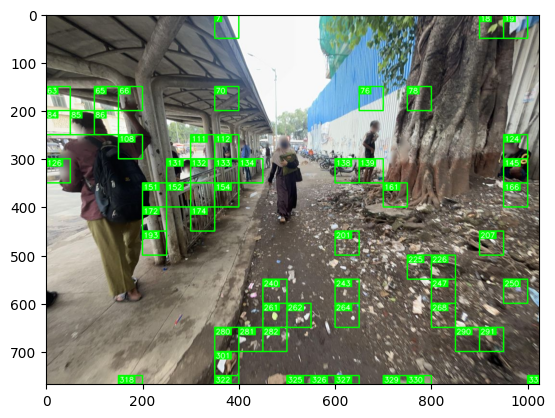

In [ ]:
from mtrain.smallnet.predict import tile_image_and_predict
res = tile_image_and_predict(TEST_BIG_IMG, learner)
plt.imsave(EXP_BASE / "res.png", res)
plt.imshow(res)
plt.show()